# What people say about Amazon Products
by Robert Ayub Odhiambo (http://www.a4ayub.me)

## Background

Reviews are an important part of any platform where users engage. E-Commerce applications provide an added advantage to customers to buy a product with added suggestions in the form of reviews

**How do reviews help**

1. Improves credibility
2. Helps users in making a decision to buy a product or not
3. Boosts the sales for products which are good in real
4. Increases customer life time value

## The Problem

The enormous amount of reviews create problems for customers as they are not able to seggregate useful ones and make it extremely difficult to filter out informative reviews.

## The Proposed Solution

This notebook attempts to rank reviews based on their relevance with specific product in this case Home Internet while at the same time ranking down irrelevant reviews

## Approach

It is easy to classify whether a review is useful or not. However, ranking reviews on the basis of usefulness, is a complex task. Our ranking methodology is based on this information.

Splitting the dataset into two sets:
1. **Set 0** - These are reviews that are not informative, these include reviews based on delivery, customer support, packaging e.t.c and they do not exactly describe the product
2. **Set 1** - These are reviews that are informative and are better than all reviews in set 0

Something worth noting is that any review in Set 1 should always be better than all reviews of Set 0 and vice versa

**Assumption**
- From the amazon dataset, we will assume the number of up-votes for helpfulness signify relevant reviews. Depending on the rating score,we will consider a rating of five to be relevant and helpful review and anything below 5 not to be relevant and helpful

**The Workflow**
1. Label the dataset based on the relevance upvotes
2. Features Extraction
3. Pairwise Ranking
4. Classification
5. Rank on basis of relevance

## Workbench

### Import the files

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
from copy import deepcopy
import seaborn as sns

import sys
%matplotlib inline

In [27]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows',1000)
rcParams['figure.figsize'] = 18,12

### Create the dataframe from the csv

In [3]:
# Import the data
reviews_df = pd.read_csv("datasets/amazon_customer_reviews.csv",engine="python");

In [4]:
#check the shape
print("We have {} rows and {} columns of customer reviews.".format(reviews_df.shape[0],reviews_df.shape[1]))

We have 28332 rows and 24 columns of customer reviews.


In [5]:
# check the info
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
id                     28332 non-null object
dateAdded              28332 non-null object
dateUpdated            28332 non-null object
name                   28332 non-null object
asins                  28332 non-null object
brand                  28332 non-null object
categories             28332 non-null object
primaryCategories      28332 non-null object
imageURLs              28332 non-null object
keys                   28332 non-null object
manufacturer           28332 non-null object
manufacturerNumber     28332 non-null object
reviews.date           28332 non-null object
reviews.dateSeen       28332 non-null object
reviews.didPurchase    9 non-null object
reviews.doRecommend    16086 non-null object
reviews.id             41 non-null float64
reviews.numHelpful     16115 non-null float64
reviews.rating         28332 non-null int64
reviews.sourceURLs     28332 non-null obje

In [6]:
# select only the necessary fields
reviews_df = reviews_df[["name","reviews.rating","reviews.text"]]
reviews_df.head()

,name,reviews.rating,reviews.text
0,AmazonBasics AAA Performance Alkaline Batteries (36 Count),3,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.
1,AmazonBasics AAA Performance Alkaline Batteries (36 Count),4,Bulk is always the less expensive way to go for products like these
2,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,Well they are not Duracell but for the price i am happy.
3,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,Seem to work as well as name brand batteries at a much better price
4,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,These batteries are very long lasting the price is great.


In [7]:
# check the rating values
reviews_df["reviews.rating"].value_counts()

5    19897
4    5648 
3    1206 
1    965  
2    616  
Name: reviews.rating, dtype: int64

In [8]:
# check the product values
reviews_group_by_name = reviews_df.groupby(['name','reviews.rating'])
reviews_group_by_name_df = pd.DataFrame({'count':reviews_group_by_name.size()}).reset_index()


In [9]:
reviews_group_by_name_df.head()

,name,reviews.rating,count
0,"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",1,1
1,"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",2,1
2,"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",3,2
3,"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",4,23
4,"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",5,55


In [10]:
reviews_group_by_name_df.sort_values(by='count',ascending=False)

,name,reviews.rating,count
100,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,6234
95,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,5,2772
139,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",5,1642
28,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",5,1583
158,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",5,1114
148,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",5,949
99,AmazonBasics AAA Performance Alkaline Batteries (36 Count),4,947
153,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",5,805
138,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",4,683
27,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",4,660


In [11]:
# filter out reviews with count greater than 100
reviews_with_100_or_more_interactions_df = reviews_group_by_name_df[reviews_group_by_name_df['count'] >= 100]
reviews_with_100_or_more_interactions_df.sort_values(by='count',ascending=False)

,name,reviews.rating,count
100,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,6234
95,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,5,2772
139,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",5,1642
28,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",5,1583
158,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",5,1114
148,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",5,949
99,AmazonBasics AAA Performance Alkaline Batteries (36 Count),4,947
153,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",5,805
138,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",4,683
27,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",4,660


In [12]:
reviews_with_100_or_more_interactions_df["reviews.rating"].value_counts()

5    19
4    12
3    2 
2    2 
1    2 
Name: reviews.rating, dtype: int64

In [13]:
# Get the reviews for the above products
products_list = [
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)	",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",
    "Amazon Tap Smart Assistant Alexaenabled (black) Brand New",
    "Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
    "Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",
    "Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers",
    "All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Amazon Tap Smart Assistant Alexaenabled (black) Brand New",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers"
]

selected_reviews_df = reviews_df[reviews_df.name.isin(products_list)]

In [14]:
selected_reviews_df.head()

,name,reviews.rating,reviews.text
0,AmazonBasics AAA Performance Alkaline Batteries (36 Count),3,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.
1,AmazonBasics AAA Performance Alkaline Batteries (36 Count),4,Bulk is always the less expensive way to go for products like these
2,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,Well they are not Duracell but for the price i am happy.
3,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,Seem to work as well as name brand batteries at a much better price
4,AmazonBasics AAA Performance Alkaline Batteries (36 Count),5,These batteries are very long lasting the price is great.


In [15]:
# confirm that we have 37 records
selected_reviews_df.shape

(27227, 3)

In [16]:
selected_reviews_df["reviews.rating"].value_counts()

5    19136
4    5384 
3    1168 
1    939  
2    600  
Name: reviews.rating, dtype: int64

In [17]:
# Assuming that a rating of 5 is synonymous to a good review and anything else is not a relevant review then we can 
#create a new dataframe with only two labels
rating_mapping_dict = {5 : 1 , 4 : 0, 3 : 0, 2 : 0, 1 : 0}
selected_reviews_df["reviews.rating"] = selected_reviews_df["reviews.rating"].map(rating_mapping_dict)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [18]:
selected_reviews_df["reviews.rating"].value_counts()

1    19136
0    8091 
Name: reviews.rating, dtype: int64

In [25]:
# Label Analysis using crosstab
label_analysis = pd.crosstab(selected_reviews_df["name"],selected_reviews_df["reviews.rating"],margins="All")
label_analysis

reviews.rating,0,1,All
name,,,
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",54,179,233
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",79,214,293
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",292,591,883
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",47,113,160
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",787,1583,2370
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",47,109,156
Amazon Tap Smart Assistant Alexaenabled (black) Brand New,199,402,601
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,956,2772,3728
AmazonBasics AAA Performance Alkaline Batteries (36 Count),2109,6234,8343


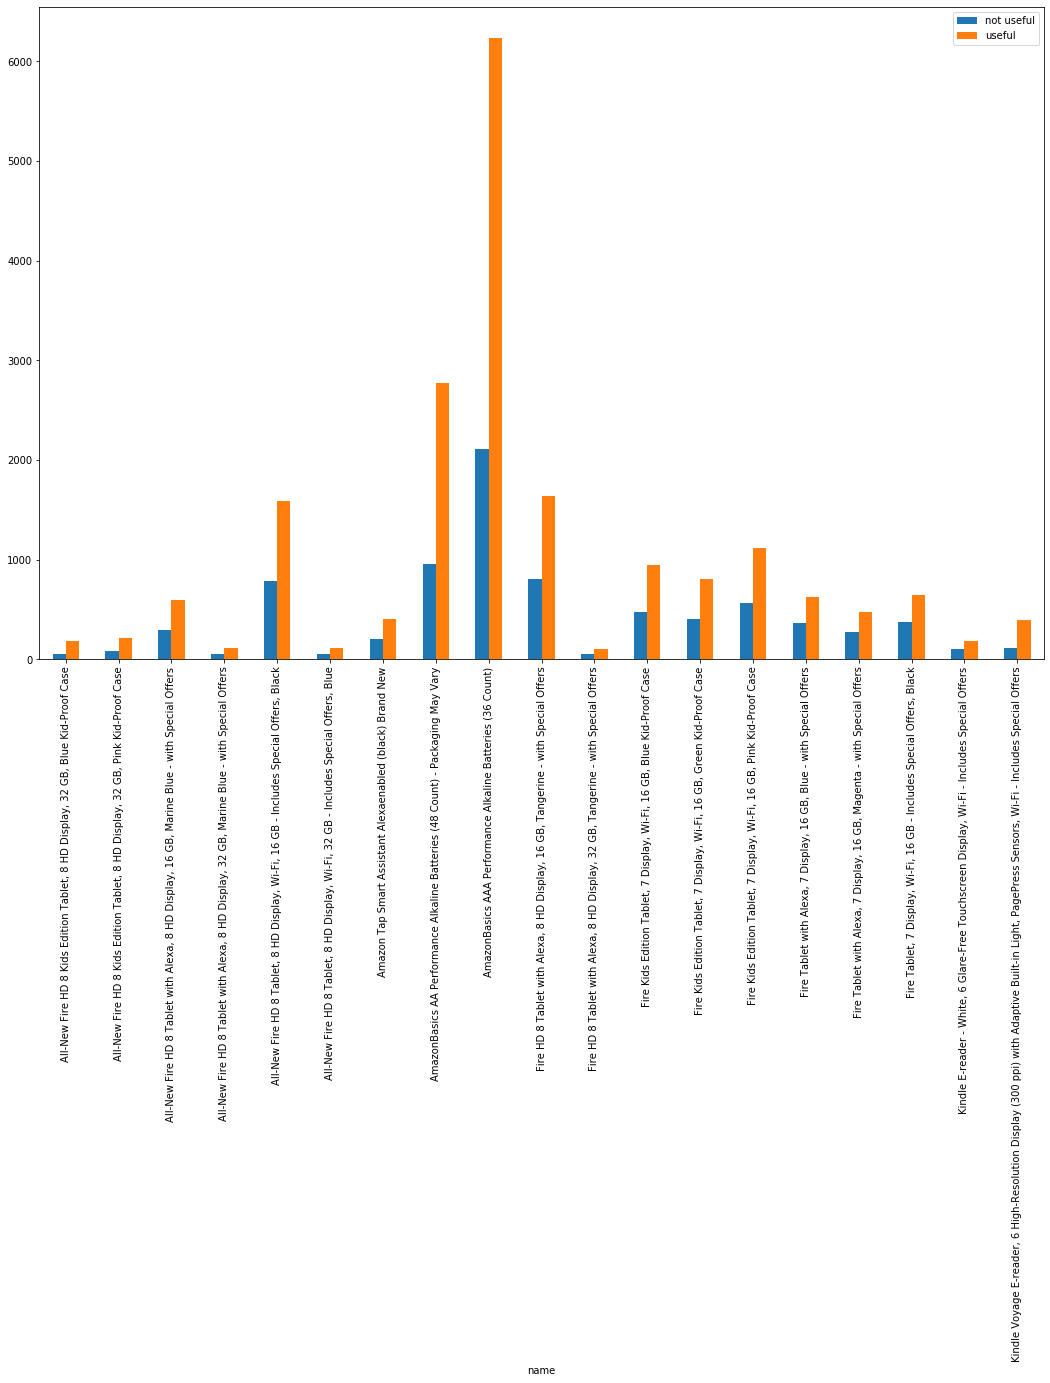

In [30]:
# Tabulation of Crostab
analysis = label_analysis.reset_index()
analysis.columns = ["name","not useful","useful","All"]
analysis.iloc[:-1].plot(x="name",y=["not useful","useful"],kind="bar")

In [31]:
# Check the length of the reviews
selected_reviews_df["review_length"] = selected_reviews_df["reviews.text"].apply(lambda x: len(x.split()))

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
selected_reviews_df.head()

,name,reviews.rating,reviews.text,review_length
0,AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,31
1,AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,Bulk is always the less expensive way to go for products like these,13
2,AmazonBasics AAA Performance Alkaline Batteries (36 Count),1,Well they are not Duracell but for the price i am happy.,12
3,AmazonBasics AAA Performance Alkaline Batteries (36 Count),1,Seem to work as well as name brand batteries at a much better price,14
4,AmazonBasics AAA Performance Alkaline Batteries (36 Count),1,These batteries are very long lasting the price is great.,10


In [33]:
# Bucket reviews based on the length
checklen = []
for i in range(5,50,5):
    checklen.append(len(selected_reviews_df[ (selected_reviews_df["review_length"] >= i-5 ) & (selected_reviews_df["review_length"] < i) ]))

In [34]:
checklen

[3360, 3155, 5443, 3811, 2590, 1862, 1327, 1087, 828]

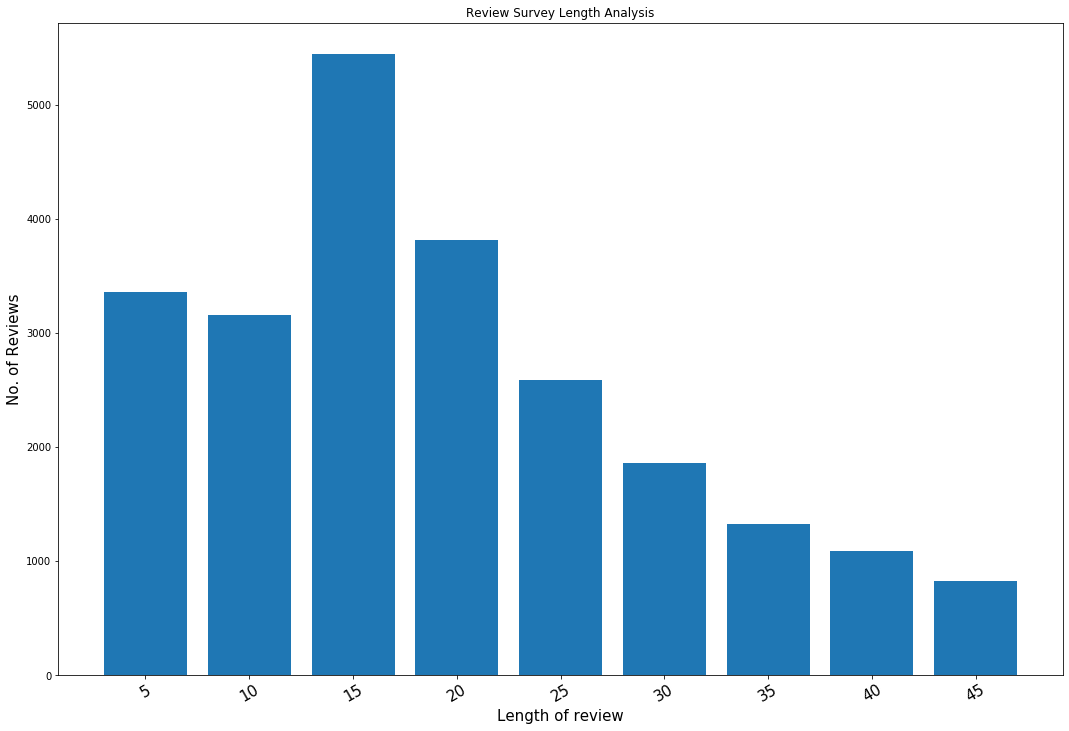

In [36]:
#Plot the review buckets
index = np.arange(len(checklen))
plt.bar(index,checklen)
plt.xlabel("Length of review",fontsize=15)
plt.ylabel("No. of Reviews",fontsize=15)
plt.xticks(index,range(5,50,5),fontsize=15,rotation=30)
plt.title("Review Survey Length Analysis")
plt.show()

### Language Detection

In [41]:
#bad_reviews = []
#for indx in selected_reviews_df.index:
#    review = selected_reviews_df.at[indx,"reviews.text"]
#    try:
#        b = rf.language_detection(review)
#        if b == "hi" or b == "mr":
#            bad_reviews.append(indx)
#    except:
#        bad_reviews.append(indx)
#        print("Language exception for:",review)

In [42]:
#print("The number of bad reviews are : {}".format(len(bad_reviews)))

In [43]:
#selected_reviews_df[selected_reviews_df.index.isin(bad_reviews)]